In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

### Codigo Prinicipal

In [54]:
def find_rt60(audio_path, plot=True, values=True, name_df='col'):
    y, sr = librosa.load(audio_path, sr=96000)

    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

    target_frequencies = [250, 500, 1000, 2000, 4000, 8000, 16000]
    colors_frequencies = ["b", "g", 'orange', "c", "m", "y", "r"]

    frequency_indices = [np.argmin(np.abs(librosa.fft_frequencies(sr=sr) - f)) for f in target_frequencies]

    time = librosa.times_like(D, sr=sr)

    amplitudes_dB = []
    for index in frequency_indices:
        amplitude_dB = D[index]
        amplitudes_dB.append(amplitude_dB)

    if plot:
        cmap = 'Greys_r'

        plt.figure(figsize=(10.4, 5))
        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', cmap=cmap)

        plt.colorbar(format='%+2.0f dB')
        plt.ylabel('Frequencies (Hz)')
        plt.xlabel('Time (s)')
        plt.title('Audio Signal Spectrogram')
        plt.show()

        plt.figure(figsize=(10, 5))
        for index, freq, color in zip(frequency_indices, target_frequencies, colors_frequencies):
            amplitude_dB = D[index]
            plt.plot(time, amplitude_dB, label=f'{freq} Hz', color=color)
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude (dB)')
        plt.title('Amplitude in dB of Frequencies over Time')
        plt.legend()
        plt.show()

    index = 0
    rt_values = []

    for i in amplitudes_dB:
        if i.mean() != -80:
            targets = None
            size = np.argmax(i)
            max(i)
            rt60 = max(i) - 60

            def find_nearest_value_position(array, value):
                lesser_index = None

                for j, number in enumerate(array):
                    if number < value and lesser_index is None:
                        lesser_index = j

                greater_index = lesser_index - 1

                return lesser_index

            def find_consecutive_values(lst, desired_value):
                consecutives = 0

                for j, val in enumerate(lst):
                    if val == desired_value:
                        consecutives += 1
                    else:
                        consecutives = 0

                    if consecutives == 10:
                        return j - 7

                return None

            final_value = int(find_consecutive_values(i[size:], -80)) + size

            numbers = i[np.argmax(i):]

            desired_number = max(i) - 60

            position = find_nearest_value_position(numbers, desired_number)

            timeRT = round(time[position], 4)

            rt60 = timeRT

            final_time = find_consecutive_values(i[size:], -80)

            position_rt_time = position
            position_rt_amplitude = i[size + position]
            initial_time = i[size:size + find_consecutive_values(i[size:], -80)]

            if plot:
                plt.figure(figsize=(10, 4))
                plt.plot(time[:final_time], initial_time, color=colors_frequencies[index], zorder=1)
                plt.scatter(time[0], initial_time[0], color=colors_frequencies[index], zorder=4, label=f"Peak ({round(time[0], 2)} [s],{str(np.round(initial_time[0], 2))} [dB]")
                plt.scatter(time[position_rt_time], position_rt_amplitude, color='k', zorder=4, label=f'RT60 ({timeRT} [s], {round(desired_number, 2)} [dB])')
                plt.title(f'RT of {target_frequencies[index]}Hz is {timeRT} s')
                plt.axhline(y=position_rt_amplitude, color='k', linestyle='--')
                plt.axvline(x=0, color='k')
                plt.xlabel('Time [s]')
                plt.ylabel('Amplitude [dB]')
                plt.legend()
                plt.show()

            index = index + 1
            rt_values.append(rt60)
        else:
            rt_values.append(None)
    if values:
        file_name = 'measurements.csv'

        if os.path.exists(file_name):
            existing_df = pd.read_csv(file_name)
            new_column_name = name_df

            existing_df[new_column_name] = rt_values

            existing_df.to_csv(file_name, index=False)
        else:
            df_final = pd.DataFrame(rt_values, columns=[name_df])

            df_final.to_csv(file_name, index=False)
            print(f"DataFrame saved to {file_name}")

        return rt_values


### Creador de Graficos

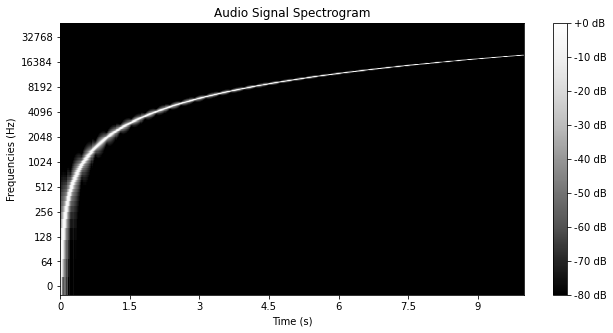

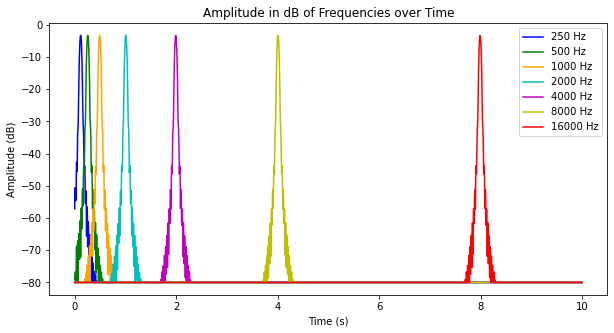

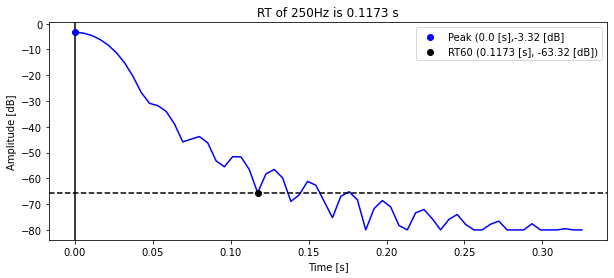

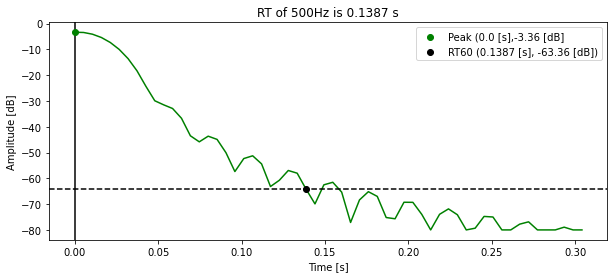

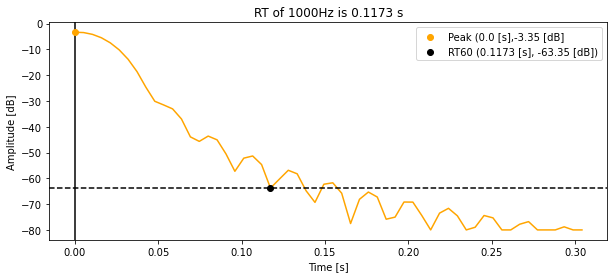

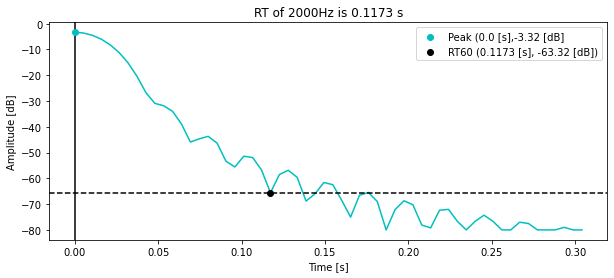

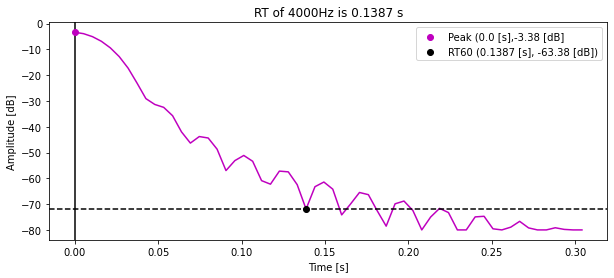

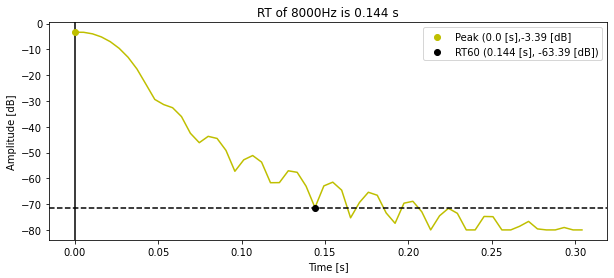

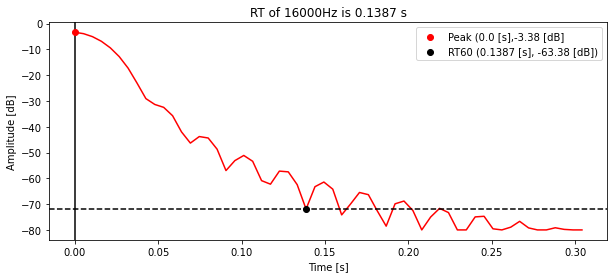

In [55]:
ReferenceSweep = find_rt60('./frecuencias/ReferenceSweep.wav',True)

### Creador de CSV

In [23]:
import os

directorio = './frecuencias/'

archivos = sorted(os.listdir(directorio))
for archivo in archivos:
    ruta_completa = os.path.join(directorio, archivo)
    
    if (archivo) != 'ReferenceSweep.wav':
        if os.path.isfile(ruta_completa):
            find_rt60(f'{directorio}{archivo}',False,True,f'{os.path.splitext(archivo)[0]}')[2]



DataFrame saved to measurements.csv


In [63]:
import pandas as pd

df = pd.read_csv('./measurements.csv')

average_row = df.mean(axis=1)

disference = np.array(round(average_row, 3)) - np.array(ReferenceSweep)

target_frequencies = [250, 500, 1000, 2000, 4000, 8000, 16000]

data = {
    'target frequencies [Hz]': target_frequencies,
    'RT 60 [s]': disference
}

df_presentation = pd.DataFrame(data,index=None)

# Imprimir el DataFrame
print(df_presentation)

   target frequencies [Hz]  RT 60 [s]
0                      250     1.2067
1                      500     1.2133
2                     1000     1.1427
3                     2000     1.1477
4                     4000     0.6333
5                     8000     0.3730
6                    16000     0.0803
